### TODO::
- Torus, sphere, klein topologies
- 3D with projection

### References
https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html

In [164]:
%pylab inline
from sandpile import *
import pandas as pd
import seaborn as sns
import numpy as np
import subprocess

sns.set(style='darkgrid')
sns.set_context('notebook', font_scale=1.5)


def trim_grid(grid):
    # Trim empty
    grid = [r for r in grid if sum(r) > 0]
    # Trim empty columns
    w1 = len(grid[0])
    trans = [[r[n] for r in grid] for n in range(w1)]
    trans = [r for r in trans if sum(r) > 0]
    w2 = len(trans[0])
    grid = [[r[n] for r in trans] for n in range(w2)]

    return grid


def visualise(data, size=30, cmap="RdYlBu"):
    '''Greys YlGnBu are also good'''
    plt.figure(figsize=(size, size))
    sns.heatmap(data, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")


def from_csv(sandPower, pattern, seed="."):
    '''
    load stored data from the csv directory
    '''
    if seed == ".":
        path = "csv/2_{}_{}.csv".format(sandPower, pattern)
    else:
        path = "csv/2_{}_{}_{}.csv".format(sandPower, pattern, seed)
    data = np.genfromtxt(path, delimiter=",")
    return trim_grid(data)


def go_run(sandPower, pattern, seed="."):
    try:
        return from_csv(sandPower, pattern, seed)
    except:
        cmd = ["go", "run", "sandpile.go"]
        args = "{} {} {}".format(sandPower, pattern, seed)
        proc = subprocess.run(cmd, input=args.encode(), shell=True, stdout=subprocess.PIPE)
        print(proc)
        return from_csv(sandPower, pattern, seed)


def animate_by_n(start_stop=(4,22), pattern='+', fps=2, trim=True, cmap="RdYlBu"):
    fig = plt.figure()
    fig.set_size_inches(5, 5, forward=True)

    data = from_csv(start_stop[0], pattern)
    ax = sns.heatmap(
            data, cbar=False, xticklabels=False,
            yticklabels=False, cmap=cmap
        )

    def init():
        ax = sns.heatmap(
                data, cbar=False, xticklabels=False,
                yticklabels=False, cmap=cmap
            )
        return ax,

    def animate(i, ax, fig):
        ax.cla()
        data = from_csv((start_stop[0] + i + 1), pattern)
        ax = sns.heatmap(
                data, cbar=False, xticklabels=False,
                yticklabels=False, cmap=cmap, ax=ax
            )
        return ax,

    anim = animation.FuncAnimation(
            fig, animate, init_func=init,
            frames=(start_stop[1] - start_stop[0]),
            fargs=(ax, fig), repeat_delay=1000,
            interval=20,
        )

    fname = "{}_{}-{}.gif".format(pattern, start_stop[0], start_stop[1])
    anim.save(fname, writer="imagemagick", fps=fps, dpi=400)
    # Trim border
    run(["convert", fname, "-fuzz", "1%", "-trim", "+repage", "-delay", "500", fname])
    # pause at the end of the loop
    print("Now run the following to put back the delay that imagemagick strips out:")
    print("convert {} \( +clone -set delay 500 \) +swap +delete {}".format(fname, fname))
    plt.show()

Populating the interactive namespace from numpy and matplotlib


Now run the following to put back the delay that imagemagick strips out:
convert x_4-22.gif \( +clone -set delay 500 \) +swap +delete x_4-22.gif


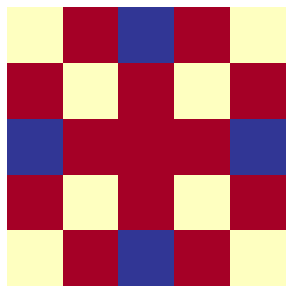

In [150]:
animate_by_n((4,22), "x")

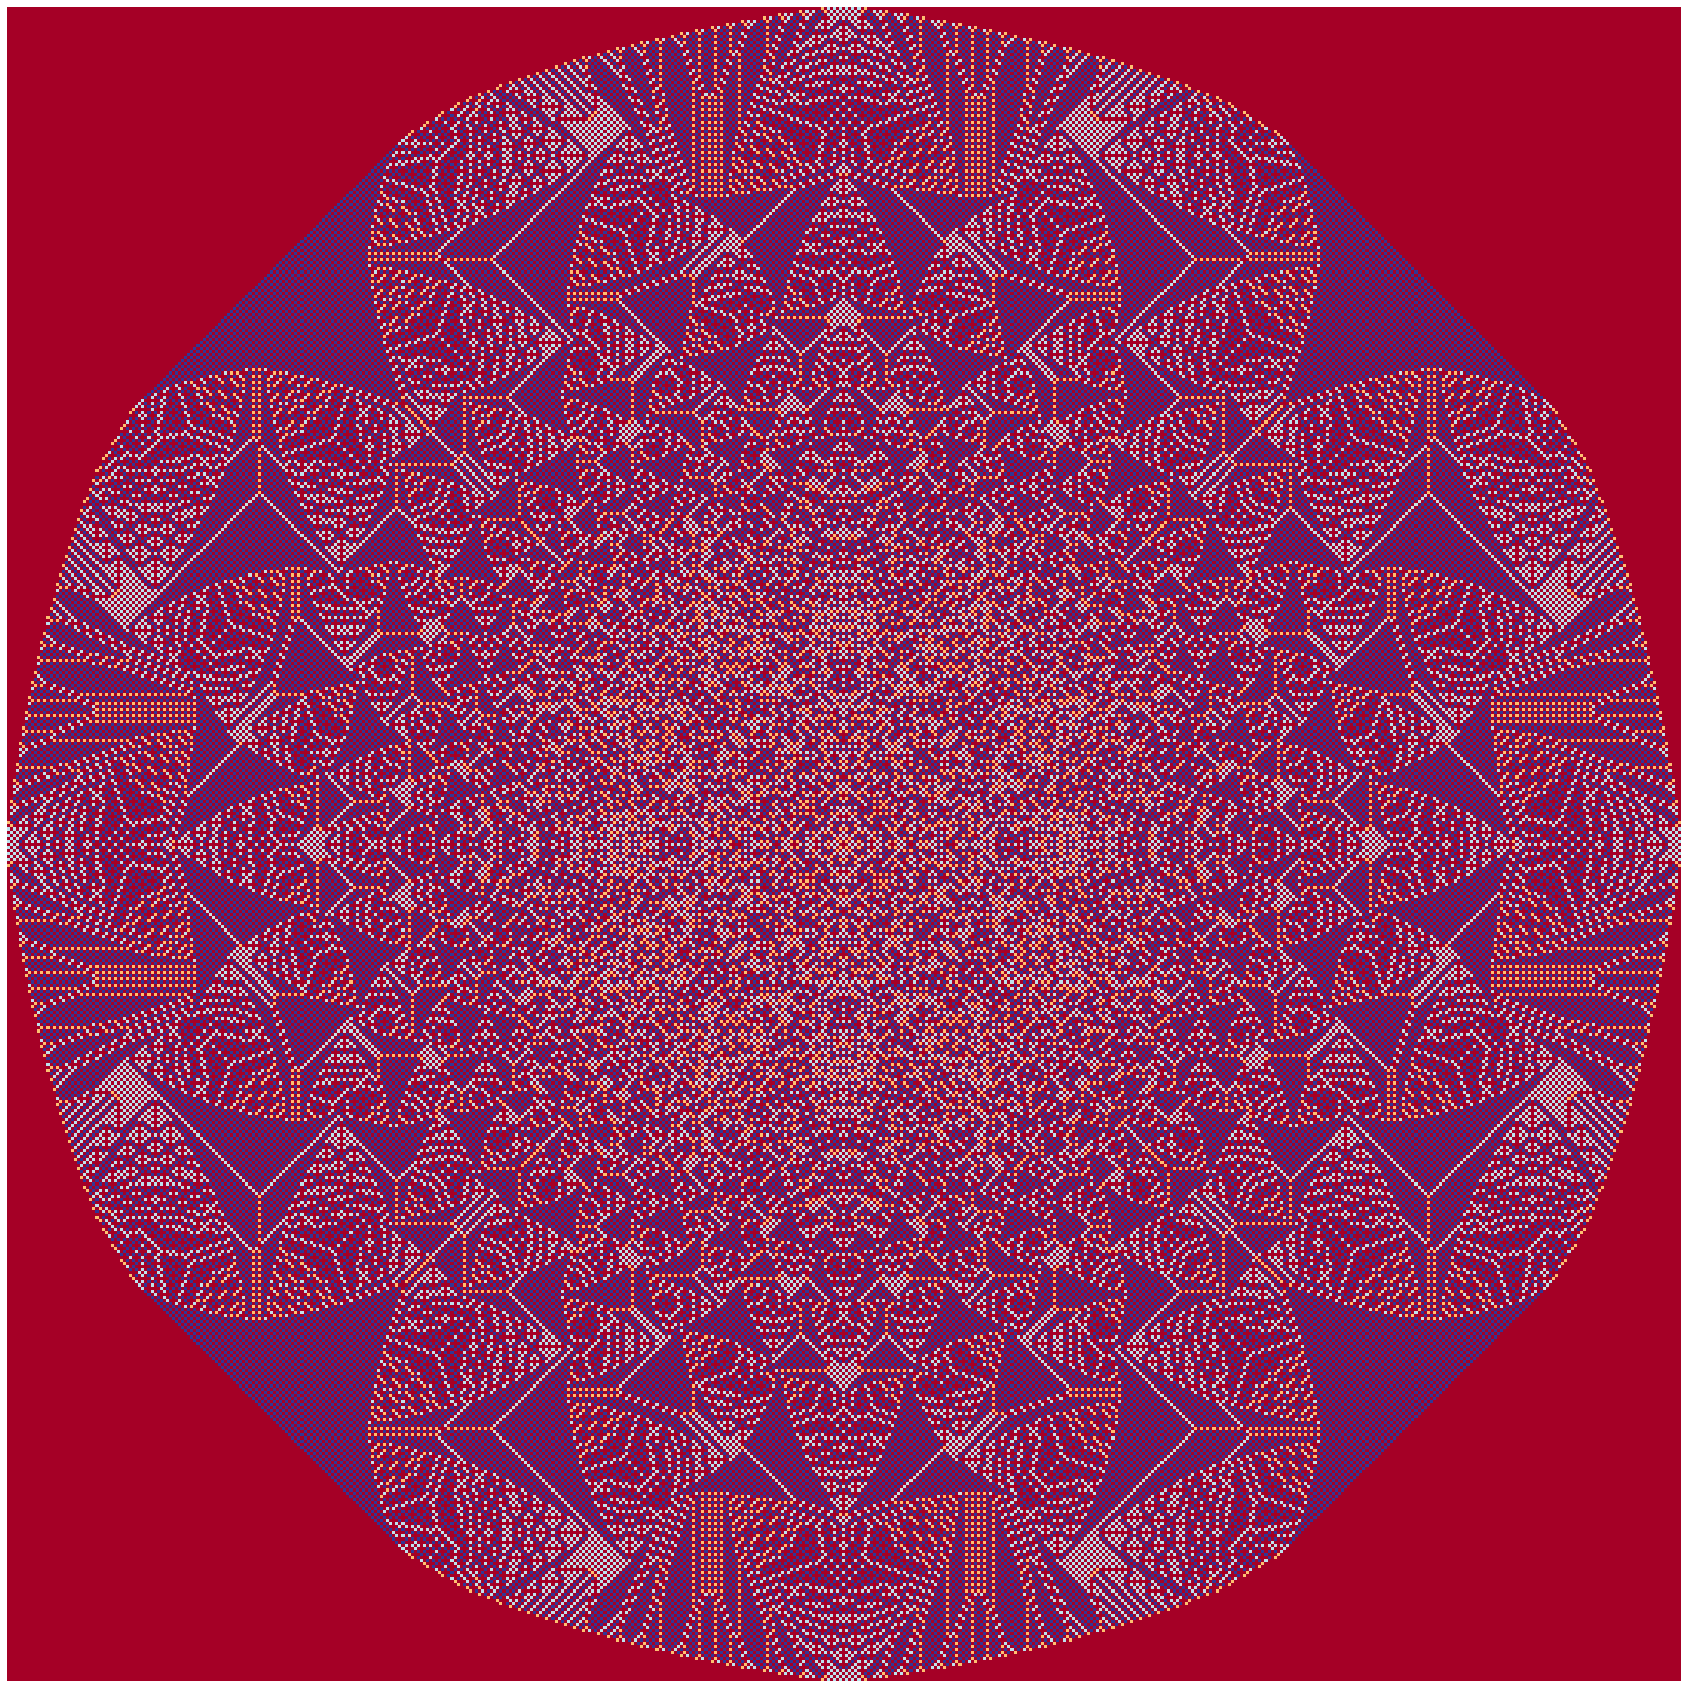

In [149]:
data = from_csv(18, "x", ".")
visualise(data, 30)

Grid initialised:
side-length 32
initial sand 1024
.........................
25 passes required
0.024130821228027344s to reach stable state


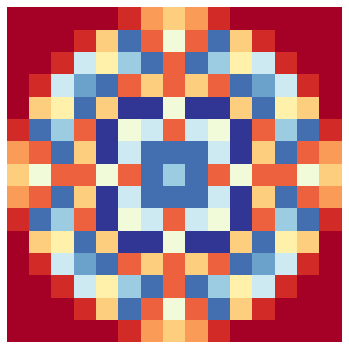

In [171]:
s = SandHeap(10, 'o+')
g = s.topple(True)
plt.figure(figsize=(6, 6))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

## Number of passes required to reach stability vs starting sand
It looks like the larger piles are allowed to be, the fewer passes are required to reach steady state. Which makes sense really: if more sand is allowed on each cell then cells reach stability sooner.

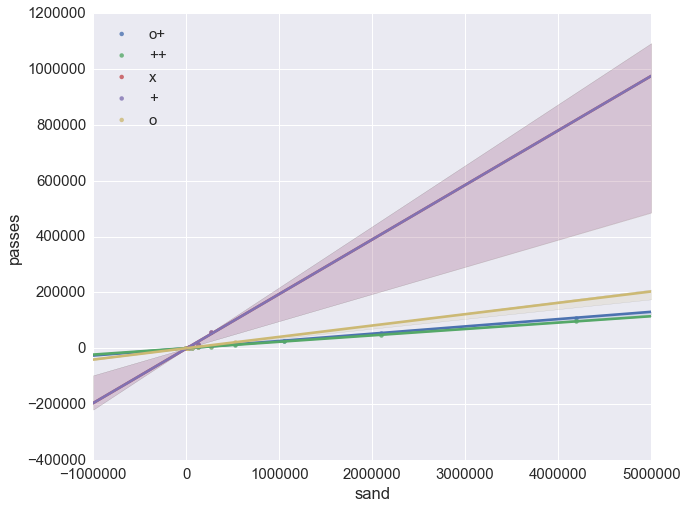

In [169]:
sandvals = [2 ** n for n in range(4,23)]

o_plusDF = pd.DataFrame(
    {"sand": sandvals,
     "passes": [2, 2, 2, 4, 6, 12, 26, 40, 91, 173, 371, 755, 1541, 3162, 6402, 13421, 25166, 54344, 110000]})
plus_plusDF = pd.DataFrame(
    {"sand": sandvals,
     "passes": [2, 2, 3, 3, 7, 12, 24, 35, 113, 209, 405, 719, 1408, 3289, 5931, 12467, 24112, 48849, 95773]})
xDF = pd.DataFrame(
    {"sand": sandvals[:15],
     "passes": [3, 4, 6, 17, 23, 51, 109, 201, 407, 787, 1864, 3102, 6436, 13300, 56948]})
plusDF = pd.DataFrame(
    {"sand": sandvals[:15],
     "passes": [3, 4, 6, 17, 23, 51, 109, 201, 407, 787, 1864, 3102, 6436, 13300, 56948]})
oDF = pd.DataFrame(
    {"sand": sandvals[:16],
     "passes": [2, 2, 3, 7, 10, 16, 32, 57, 143, 268, 534, 1299, 2360, 4585, 9195, 22036]})

plt.figure(figsize=(10, 8))
ax = sns.regplot("sand", "passes", o_plusDF, label="o+")
sns.regplot("sand", "passes", plus_plusDF, label="++")
sns.regplot("sand", "passes", xDF, label="x")
sns.regplot("sand", "passes", plusDF, label="+")
sns.regplot("sand", "passes", oDF, label="o")
ax.legend(loc=2)

### Making a GIF
Run the generation first with the verbose flag enabled to see how many steps are required to reach stable state. In general, more that a few hundred frames for the gif results in a giant filesize so adjust the step and n values to get a sensible number of frames.

##### Cmap values
`
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, 
GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, 
Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, 
Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, 
Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, 
YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, 
cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, 
gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, 
gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, 
hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, 
plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, 
summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
`

In [ ]:
animate(n=450, k=19, pat='o+', step=32, ftype='gif', fps=20, trim=False, cmap="RdYlBu")

In [ ]:
plt.figure(figsize=(18, 18))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")